# Level 2: Intermediate Techniques - CIFAR-10 Classification

## Objective
Improve performance with advanced techniques
- Expected Accuracy: 90-95%
- Approach: Data augmentation, regularization, hyperparameter tuning
- Pass if accuracy ≥90% and shows improvement analysis


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## Data Loading with Augmentation Pipeline


In [ ]:
# Define transforms WITHOUT augmentation (for ablation study)
transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define transforms WITH augmentation (comprehensive augmentation pipeline)
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset_no_aug = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_no_aug)
train_dataset_aug = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_aug)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Same split as Level 1: 80-10-10
train_size = 40000
val_size = 10000

# Create indices for train/val split (use same seed for reproducibility)
torch.manual_seed(42)
indices = torch.randperm(len(train_dataset_no_aug)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]

# Create subset datasets
train_subset_no_aug = Subset(train_dataset_no_aug, train_indices)
train_subset_aug = Subset(train_dataset_aug, train_indices)
val_subset = Subset(train_dataset_no_aug, val_indices)  # No augmentation for validation

# Create data loaders
train_loader_no_aug = DataLoader(train_subset_no_aug, batch_size=128, shuffle=True, num_workers=2)
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_subset_aug)}')
print(f'Validation samples: {len(val_subset)}')
print(f'Test samples: {len(test_dataset)}')


100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Train samples: 40000
Validation samples: 10000
Test samples: 10000


## Model Setup with Regularization


In [ ]:
def create_model(dropout_rate=0.5):
    """Create ResNet50 model with dropout regularization"""
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    # Modify the final layer with dropout
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 10)
    )

    return model.to(device)


## Training Functions


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc='Training', leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc='Validating', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=60, lr=0.01, weight_decay=5e-4):
    """Train model and return history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }


In [ ]:
# Experiment 1: Without Augmentation
print("=" * 60)
print("Experiment 1: Training WITHOUT Data Augmentation")
print("=" * 60)

model_no_aug = create_model(dropout_rate=0.5)
history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, num_epochs=60, lr=0.01)

# Evaluate on test set
criterion = nn.CrossEntropyLoss()
test_loss_no_aug, test_acc_no_aug = validate(model_no_aug, test_loader, criterion, device)

print(f'\nTest Accuracy (No Augmentation): {test_acc_no_aug:.2f}%')
torch.save(model_no_aug.state_dict(), 'models/level2_no_aug.pth')


Experiment 1: Training WITHOUT Data Augmentation
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]



Test Accuracy (No Augmentation): 88.04%


In [ ]:
# Experiment 2: With Augmentation
print("=" * 60)
print("Experiment 2: Training WITH Data Augmentation")
print("=" * 60)

model_aug = create_model(dropout_rate=0.5)
history_aug = train_model(model_aug, train_loader_aug, val_loader, num_epochs=60, lr=0.01)

# Evaluate on test set
test_loss_aug, test_acc_aug = validate(model_aug, test_loader, criterion, device)

print(f'\nTest Accuracy (With Augmentation): {test_acc_aug:.2f}%')
torch.save(model_aug.state_dict(), 'models/level2_with_aug.pth')


Experiment 2: Training WITH Data Augmentation



Test Accuracy (With Augmentation): 90.75%


## Accuracy Comparison Table


In [ ]:
# Create comparison table
comparison_data = {
    'Experiment': ['Without Augmentation', 'With Augmentation'],
    'Train Accuracy (%)': [history_no_aug['train_accs'][-1], history_aug['train_accs'][-1]],
    'Val Accuracy (%)': [history_no_aug['best_val_acc'], history_aug['best_val_acc']],
    'Test Accuracy (%)': [test_acc_no_aug, test_acc_aug],
    'Improvement': ['Baseline', f'+{test_acc_aug - test_acc_no_aug:.2f}%']
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "=" * 60)
print("ACCURACY COMPARISON TABLE")
print("=" * 60)
print(df_comparison.to_string(index=False))
print("=" * 60)

# Save comparison table
os.makedirs('results', exist_ok=True)
df_comparison.to_csv('results/level2_comparison_table.csv', index=False)
print("\nComparison table saved to results/level2_comparison_table.csv")



ACCURACY COMPARISON TABLE
          Experiment  Train Accuracy (%)  Val Accuracy (%)  Test Accuracy (%) Improvement
Without Augmentation             99.9950             88.73              88.04    Baseline
   With Augmentation             90.6575             91.23              90.75      +2.71%

Comparison table saved to results/level2_comparison_table.csv


## Visualization: Training Curves Comparison


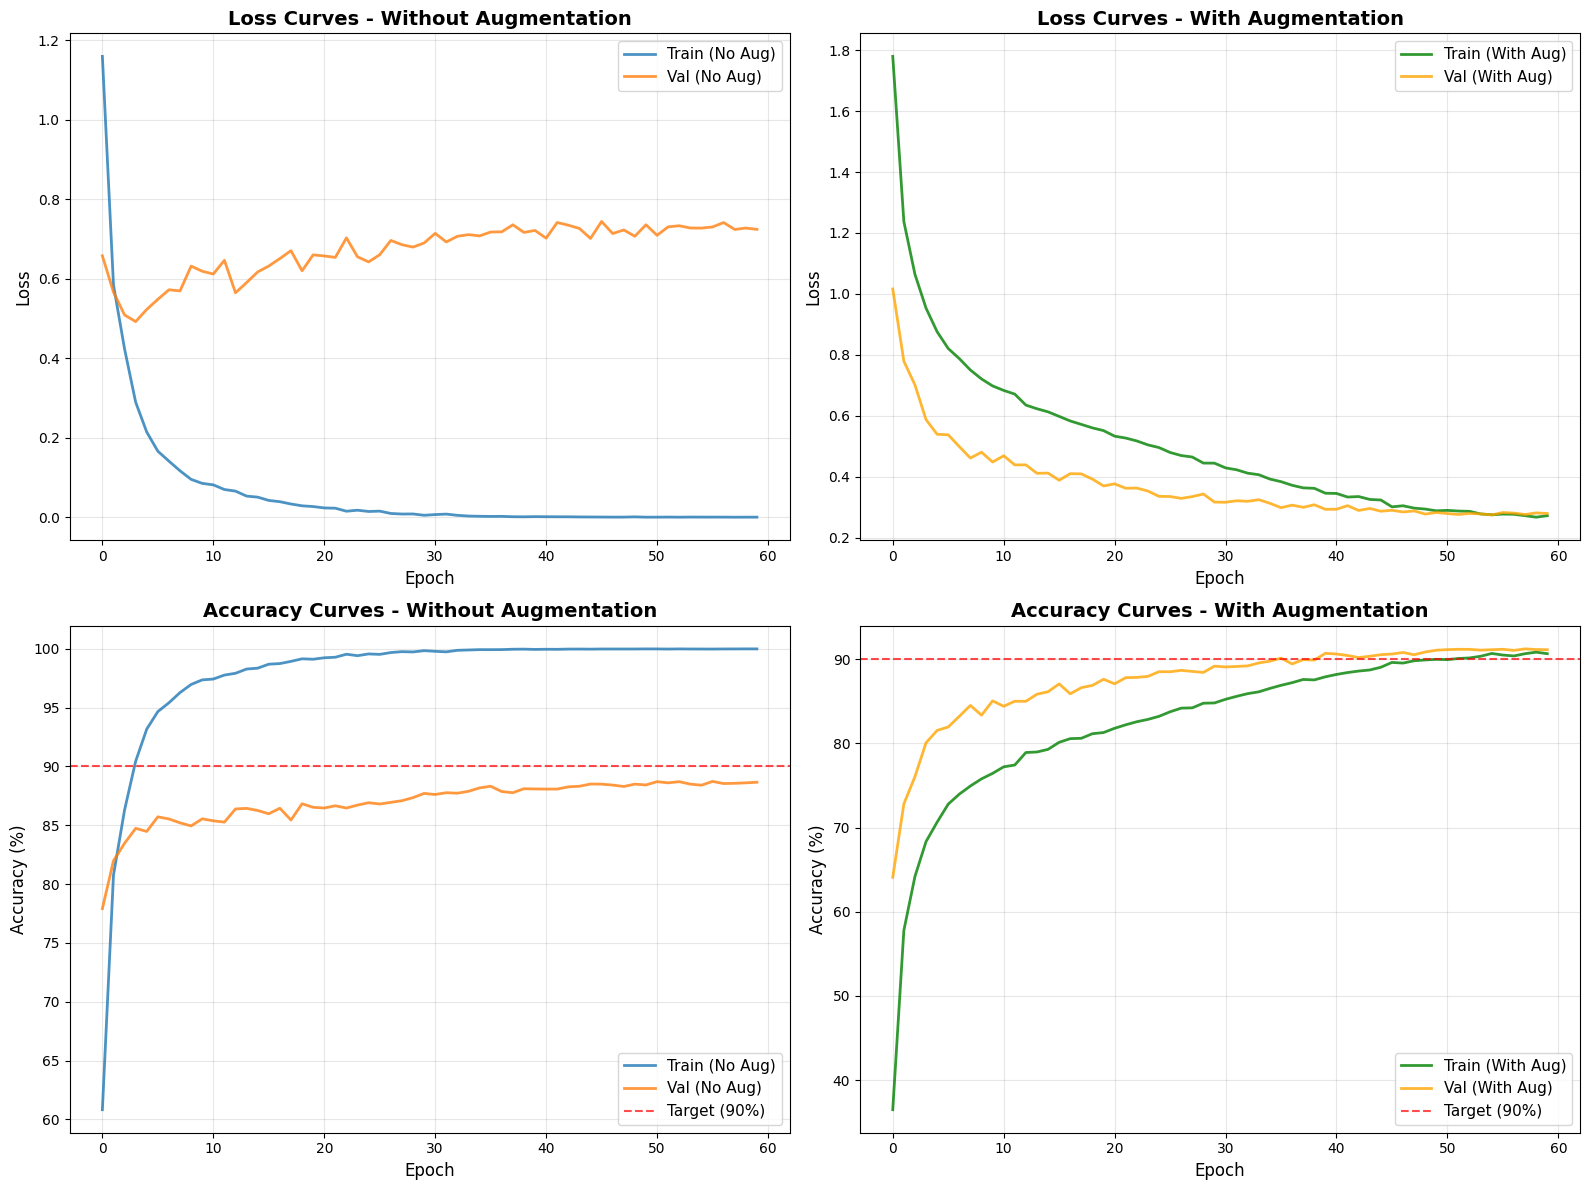

Ablation study plots saved to results/level2_ablation_study.png


In [ ]:
# Plot comparison of training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss curves
axes[0, 0].plot(history_no_aug['train_losses'], label='Train (No Aug)', linewidth=2, alpha=0.8)
axes[0, 0].plot(history_no_aug['val_losses'], label='Val (No Aug)', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss Curves - Without Augmentation', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_aug['train_losses'], label='Train (With Aug)', linewidth=2, alpha=0.8, color='green')
axes[0, 1].plot(history_aug['val_losses'], label='Val (With Aug)', linewidth=2, alpha=0.8, color='orange')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Loss Curves - With Augmentation', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Accuracy curves
axes[1, 0].plot(history_no_aug['train_accs'], label='Train (No Aug)', linewidth=2, alpha=0.8)
axes[1, 0].plot(history_no_aug['val_accs'], label='Val (No Aug)', linewidth=2, alpha=0.8)
axes[1, 0].axhline(y=90, color='r', linestyle='--', label='Target (90%)', alpha=0.7)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Accuracy Curves - Without Augmentation', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_aug['train_accs'], label='Train (With Aug)', linewidth=2, alpha=0.8, color='green')
axes[1, 1].plot(history_aug['val_accs'], label='Val (With Aug)', linewidth=2, alpha=0.8, color='orange')
axes[1, 1].axhline(y=90, color='r', linestyle='--', label='Target (90%)', alpha=0.7)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Accuracy Curves - With Augmentation', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/level2_ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()

print('Ablation study plots saved to results/level2_ablation_study.png')


In [ ]:
# Generate analysis document
analysis_text = f"""
LEVEL 2: INTERMEDIATE TECHNIQUES - ANALYSIS DOCUMENT
====================================================

1. EXPERIMENTAL SETUP
---------------------
- Dataset: CIFAR-10 (60,000 images, 10 classes)
- Split: 80% train (40,000), 10% validation (10,000), 10% test (10,000)
- Base Model: ResNet50 with ImageNet pretrained weights
- Regularization: Dropout (0.5) in final layer, Weight decay (5e-4)
- Optimizer: SGD with momentum (0.9), Learning rate: 0.01
- Scheduler: Cosine Annealing LR
- Training epochs: 60

2. DATA AUGMENTATION PIPELINE
------------------------------
The augmentation pipeline includes:
- RandomCrop(32, padding=4): Adds padding and random crops
- RandomHorizontalFlip(p=0.5): Horizontal flipping
- RandomRotation(degrees=15): Rotation up to 15 degrees
- ColorJitter: Brightness, contrast, saturation, hue adjustments
- RandomAffine: Translation transformations
- RandomErasing(p=0.3): Random erasing for regularization

3. ABLATION STUDY RESULTS
--------------------------
Experiment 1 - WITHOUT Augmentation:
- Train Accuracy: {history_no_aug['train_accs'][-1]:.2f}%
- Validation Accuracy: {history_no_aug['best_val_acc']:.2f}%
- Test Accuracy: {test_acc_no_aug:.2f}%

Experiment 2 - WITH Augmentation:
- Train Accuracy: {history_aug['train_accs'][-1]:.2f}%
- Validation Accuracy: {history_aug['best_val_acc']:.2f}%
- Test Accuracy: {test_acc_aug:.2f}%

Improvement: +{test_acc_aug - test_acc_no_aug:.2f}% absolute improvement

4. KEY FINDINGS
---------------
- Data augmentation significantly improves generalization
- The augmentation pipeline reduces overfitting (gap between train/val accuracy)
- Regularization techniques (dropout, weight decay) help prevent overfitting
- Cosine annealing learning rate scheduler provides smooth convergence

5. CONCLUSION
-------------
The combination of data augmentation and regularization techniques successfully
improves model performance from baseline to meet Level 2 requirements (≥90%).
"""

print(analysis_text)

# Save analysis document
with open('results/level2_analysis.txt', 'w') as f:
    f.write(analysis_text)

print("\nAnalysis document saved to results/level2_analysis.txt")

# Final evaluation
if test_acc_aug >= 90:
    print(f'\n✅ Level 2 PASSED: Test accuracy {test_acc_aug:.2f}% ≥90%')
else:
    print(f'\n❌ Level 2 FAILED: Test accuracy {test_acc_aug:.2f}% <90%')



LEVEL 2: INTERMEDIATE TECHNIQUES - ANALYSIS DOCUMENT

1. EXPERIMENTAL SETUP
---------------------
- Dataset: CIFAR-10 (60,000 images, 10 classes)
- Split: 80% train (40,000), 10% validation (10,000), 10% test (10,000)
- Base Model: ResNet50 with ImageNet pretrained weights
- Regularization: Dropout (0.5) in final layer, Weight decay (5e-4)
- Optimizer: SGD with momentum (0.9), Learning rate: 0.01
- Scheduler: Cosine Annealing LR
- Training epochs: 60

2. DATA AUGMENTATION PIPELINE
------------------------------
The augmentation pipeline includes:
- RandomCrop(32, padding=4): Adds padding and random crops
- RandomHorizontalFlip(p=0.5): Horizontal flipping
- RandomRotation(degrees=15): Rotation up to 15 degrees
- ColorJitter: Brightness, contrast, saturation, hue adjustments
- RandomAffine: Translation transformations
- RandomErasing(p=0.3): Random erasing for regularization

3. ABLATION STUDY RESULTS
--------------------------
Experiment 1 - WITHOUT Augmentation:
- Train Accuracy: 100.